# X.9.12. Экогенетическая модель

Рассмотрим пример системы уравнений, которая описывает изменения численности популяций двух видов и эволюцию некоего генетического признака $\alpha$. Система ОДУ имеет вид

\begin{cases}
\dot{x} = x\left(1 - 0.5x - \cfrac{2}{7\alpha^2}y\right) \\
\dot{y} = y\left(2\alpha - 3.5\alpha^2x - 0.5y\right) \\
\dot{\alpha} = \varepsilon\left(2 - 7x\alpha\right) \\
\end{cases}

Параметры задачи таковы: $\varepsilon \le 0.01, 0 \le x_0 \le 3, 0 \le y_0 \le 15, 0 < \alpha_0 \ll 1, T_k = 1500$. Наличие малого параметра в третьем уравнении системы показывает, что генетический признак меняется медленнее, чем численность популяций. Решение системы — релаксационные колебания.

Задача описана в статье: [Кондрашов А.С., Хибник А.И. Экогенетические модели как быстро-медленные
системы // Исследования по математической биологии. Пущино, 1996. С. 88–123.](http://elibrary.sgu.ru/VKR/2016/02-03-03_008.pdf)

In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

In [99]:
# du/dt = evolution(t, u)
def evolution(t, u):
    x, y, alpha = u
    return np.array([x*(1 - 0.5*x - 2*y/(7*(alpha**2))), 
                     y*(2*alpha - 3.5*x*(alpha**2) - 0.5*y), 
                     eps*(2 - 7*alpha*x)])

Решать задачу будем явными **методами Рунге-Кутты 2-го, 3-го и 4-го порядков** со следующими таблицами Бутчера (взято [отсюда](https://mipt.ru/education/chair/computational_mathematics/upload/9d5/rk.pdf)):

$$
\overset{\text{2 порядок (Метод Эйлера)}}{
\begin{array}{c|cc}
0 & \\
1/2 & 1/2 \\ \hline
& 0 & 1
\end{array}}
\qquad
\overset{\text{3 порядок (Метод Хойна)}}{
\begin{array}{c|ccc}
0 & \\
1/3 & 1/3 \\
2/3 & 0 & 2/3 \\ \hline
& 1/4 & 0 & 3/4
\end{array}}
\qquad
\overset{\text{4 порядок}}{
\begin{array}{c|cccc}
0 & \\
1/2 & 1/2 \\
1/2 & 0 & 1/2 \\
1   & 0 & 0 &1 \\ \hline
& 1/6 & 1/3 & 1/3 & 1/6
\end{array}}
$$ 

In [100]:
def rk2(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    return u + tau * k2
rk2.order = 2; rk2.name = 'Метод Рунге-Кутты 2 порядка (метод Эйлера)'

def rk3(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t +   tau/3, u + k1*tau/3)
    k3 = f(t + 2*tau/3, u + k2*2*tau/3)
    return u + tau * (k1 + 3*k3) / 4
rk3.order = 3; rk3.name = 'Метод Рунге-Кутты 3 порядка (метод Хойна)'

def rk4(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    k3 = f(t + tau/2, u + tau/2*k2)
    k4 = f(t + tau  , u + tau  *k3)
    return u + tau * (k1 + 2*k2 + 2*k3 + k4) / 6
rk4.order = 4; rk4.name = 'Метод Рунге-Кутты 4 порядка'

Будем использовать неравномерную сетку по времени. Будем выбирать шаг так, чтобы погрешность метода на каждом интервале $[t_\text{n},t_\text{n+1}]$ не превышала заданную величину $\varepsilon$ (в нашем случае 0.01).

**Правило Рунге для оценки точности численного решения ОДУ:**
Для оценки требуется решить задачу на 2 сетках: один раз с шагом $\tau$ ($y_{i,\tau}$) и второй — с шагом $\tau/2$ ($y_{i,\tau/2}$). Тогда формула для погрешности решения: 
$$\text{err} = \cfrac{|y_{{i,\tau}} - y_{{i,\tau/2}}|}{2^{p} - 1},$$
где p — порядок точности численного метода

Обновленный шаг будем задавать по данной формуле:

$$\tau_\text{new} = \tau \cdot \min \left\{\beta_\text{max}, \max\left(\beta_\text{min}, \beta\left(\cfrac{\varepsilon}{\text{err}}\right)^{1/(p+1)}\right)\right\},$$

где $\beta_\text{max}, \beta_\text{min}$ — максимально и манимальное разрешенное изменение шага, $\beta$ — гарантированный множитель (служит для того, чтобы в случае резкого уменьшения шага численный метод оставался устойчивым)

In [101]:
def steps(func, init_start, t_max, method, epsilon, tau=0.1):
    p = method.order
    name = method.name
    u = init_start
    t = 0
    T = [0]          # список точек по времени
    U = [init_start] # список значений в моменты времени T
    bad = 0          # количество случаев, когда правило Рунге не выполнилось
    
    while t < t_max:
        if t + tau > t_max:
            tau = t_max - t     # случай последнего шага
        u1 = method(func, tau, t, u)          # шаг tau (целый)   
        u2 = method(func, tau/2, t, u)        
        u2 = method(func, tau/2, t+tau/2, u2) # два полушага по tau/2   
        err = np.linalg.norm(u1 - u2)/(2**p - 1)      # правило Рунге    
        taunew = tau * min(2, max(0.25, 0.8 * (epsilon/err)**(1 / (p+1)))) # обновленный шаг
        if err < epsilon:           
            t += tau
            u = u1            
            T.append(t) 
            U.append(u)
        else: 
            bad += 1
        tau = taunew
        
    print('{} \n  Количество шагов: {} \n  Отброшено шагов: {}\n'.format(name, len(T)-1, bad))
    return np.array(T), np.array(U)

In [102]:
# параметры системы
eps = 0.01
Tmax = 1500
init = np.array([3, 2, 0.1]) # x = 3, y = 2, alpha = 0.1

In [103]:
def shplot(T, Y, model):
    plt.figure(figsize=(20, 10))
    #plt.ylim(-0.5, 15)
    plt.title(model.name)
    plt.plot(T, Y[:, 0], lw = 3, label='x')
    plt.plot(T, Y[:, 1], label='y')
    plt.plot(T, Y[:, 2], label=r'$\alpha$')
    plt.legend(loc='best', fontsize='xx-large')
    plt.grid()
    plt.show

Метод Рунге-Кутты 2 порядка (метод Эйлера) 
  Количество шагов: 1754 
  Отброшено шагов: 26

Метод Рунге-Кутты 4 порядка 
  Количество шагов: 1200 
  Отброшено шагов: 44



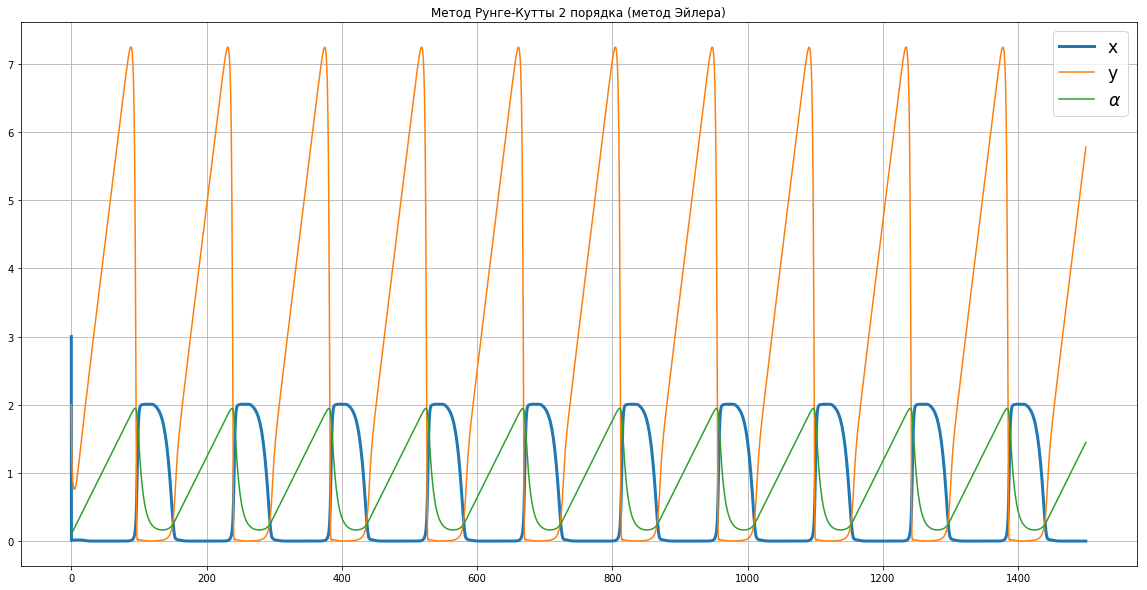

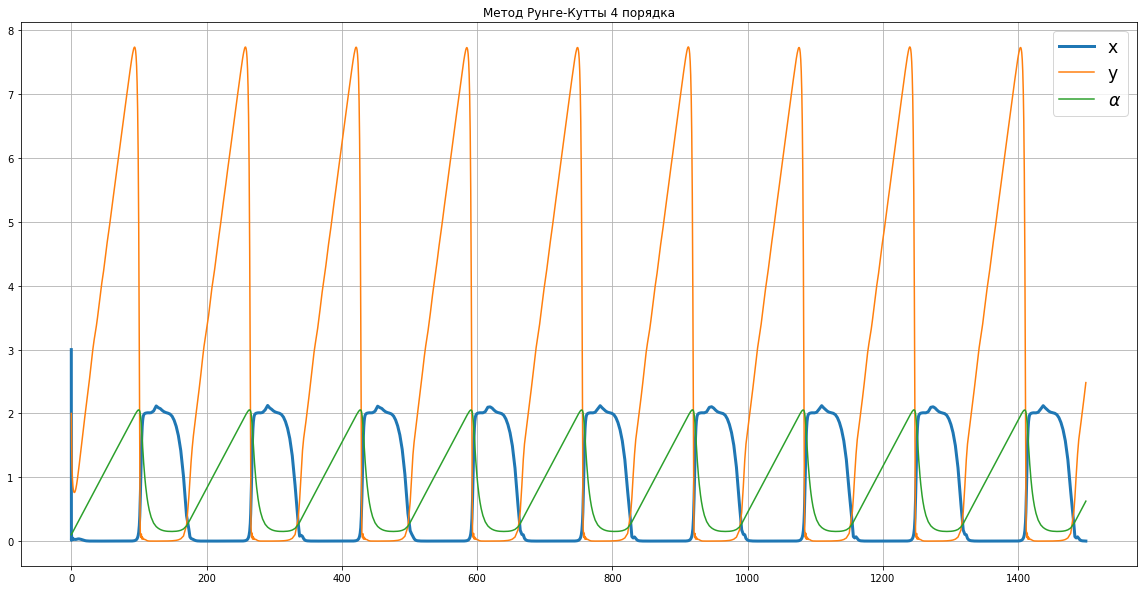

In [104]:
for rk in [rk2, rk4]:
    T, U = steps(evolution, init, Tmax, rk, eps)
    shplot(T, U, rk)

**Построим интерактивные графики:**

In [105]:
plotly.offline.init_notebook_mode(connected=True)
def plot(T, U):
    trace0 = go.Scatter(
        x = T,
        y = U[:, 0],
        mode = 'lines+markers',
        name = 'x'
    )
    trace1 = go.Scatter(
        x = T,
        y = U[:, 1],
        mode = 'lines+markers',
        name = 'y'
    )
    trace2 = go.Scatter(
        x = T,
        y = U[:, 2],
        mode = 'lines+markers',
        name = r'$\alpha$'
    )
    data = [trace0, trace1, trace2]
    layout = go.Layout(
        xaxis = dict(title='Number of iteration',
                     titlefont=dict(
                         family='Arial, sans-serif',
                         size=13,
                         color='black'
                     )
                    )
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='basic-line')

In [106]:
for rk in [rk2, rk4]:
    T, U = steps(evolution, init, Tmax, rk, eps)
    plot(T, U)

Метод Рунге-Кутты 2 порядка (метод Эйлера) 
  Количество шагов: 1754 
  Отброшено шагов: 26



Метод Рунге-Кутты 4 порядка 
  Количество шагов: 1200 
  Отброшено шагов: 44



Как видим, графики практически точно совпадают с полученными в приведенной статье. Интерпретация графиков заключается в следующем: виды попеременно и почти полностью вытесняют друг друга, и этот процесс повторяется периодически. Данный режим устанавливается в определенном диапазоне изменения генетического признака $\alpha$. 

## PS

Про метод РК 3 порядка: не дал никаких результатов: долго считался и по значениям $y$ улетал далеко вверх, в то время, когда $x$ и $\alpha$ оставались нулями. Попробовал иную реализацию РК 3 порядка (с другой таблицей Бутчера), но результаты оказались теми же, из чего сделал вывод, что данный метод не применим к решению задачи.

In [110]:
def rk3_new(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + 2*tau/3, u + 2*k1*tau/3)
    k3 = f(t + 2*tau/3, u - k1*tau/3 + k2*tau)
    return u + tau * (k1 + 2*k2 + k3) / 4
rk3_new.order = 3; rk3_new.name = 'Метод Рунге-Кутты 3 порядка (новый)'

Метод Рунге-Кутты 3 порядка (новый) 
  Количество шагов: 311 
  Отброшено шагов: 52

0.10781499999995958 seconds


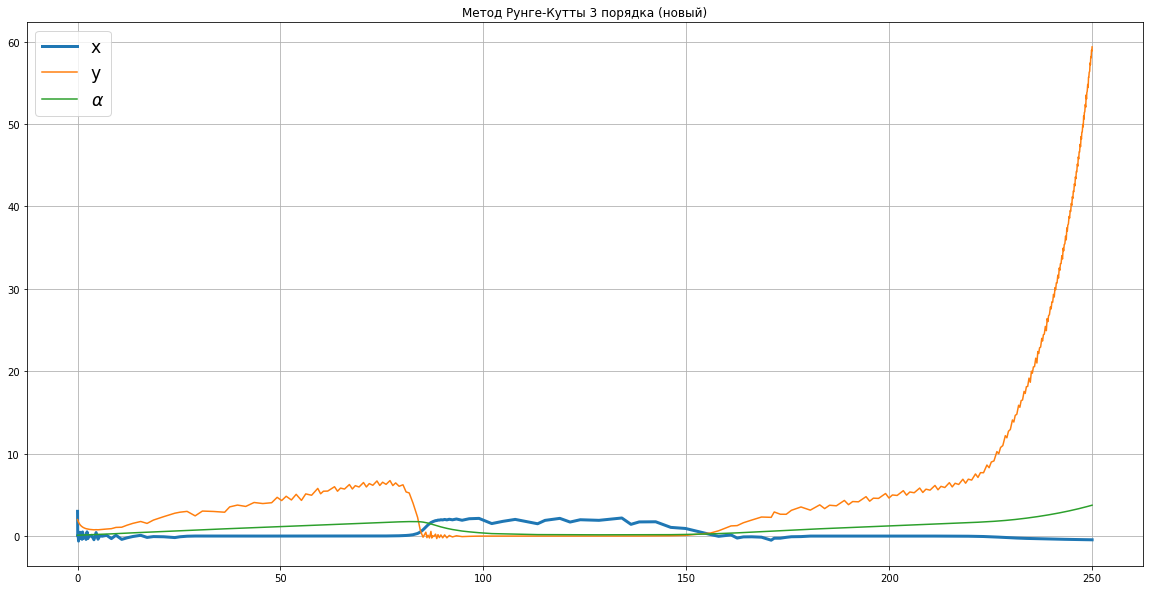

In [113]:
import time
start_time = time.clock()
T, U = steps(evolution, np.array([3, 2, 0.1]), 250, rk3_new, 0.1) # поставил количество итераций не 1500, а 250
shplot(T, U, rk3_new)
print(time.clock() - start_time, "seconds")

В начале есть намеки на искомые пики, но дальше все уходит в неверные значения